In [7]:
%pip install pandas numpy nibabel scikit-fuzzy scikit-learn gui

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement gui (from versions: none)
ERROR: No matching distribution found for gui


In [8]:
import pandas as pd
import numpy as np
import nibabel as nib
import os

import matplotlib.pyplot as plt
from matplotlib import patches

import msvcrt
import skfuzzy

import SimpleITK as sitk

from ipywidgets import interact
import ipywidgets

import skimage

In [9]:
DATA_PATH = '../../Processed NIFTI Dataset/'

annotations = pd.read_csv("segmentation_annotations_NIFTI.csv").set_index('Patient_ID')

In [10]:
annotations

,Start Row,End Row,Start Column,End Column,Start Slice,End Slice
Patient_ID,,,,,,
Breast_MRI_001,234,271,308,341,89,112
Breast_MRI_002,251,294,108,136,59,72
Breast_MRI_003,351,412,82,139,96,108
Breast_MRI_004,262,280,193,204,86,95
Breast_MRI_005,188,213,138,178,76,122
...,...,...,...,...,...,...
Breast_MRI_918,345,395,338,395,62,85
Breast_MRI_919,285,312,369,397,98,109
Breast_MRI_920,172,193,337,355,87,101


In [11]:
os.listdir(DATA_PATH + 'Breast_MRI_001')

['post_1.hdr.gz', 'post_1.img.gz', 'pre.hdr.gz', 'pre.img.gz']

In [12]:
nifti_files = ['pre.img.gz', 'post_1.img.gz']

All are within bounds!

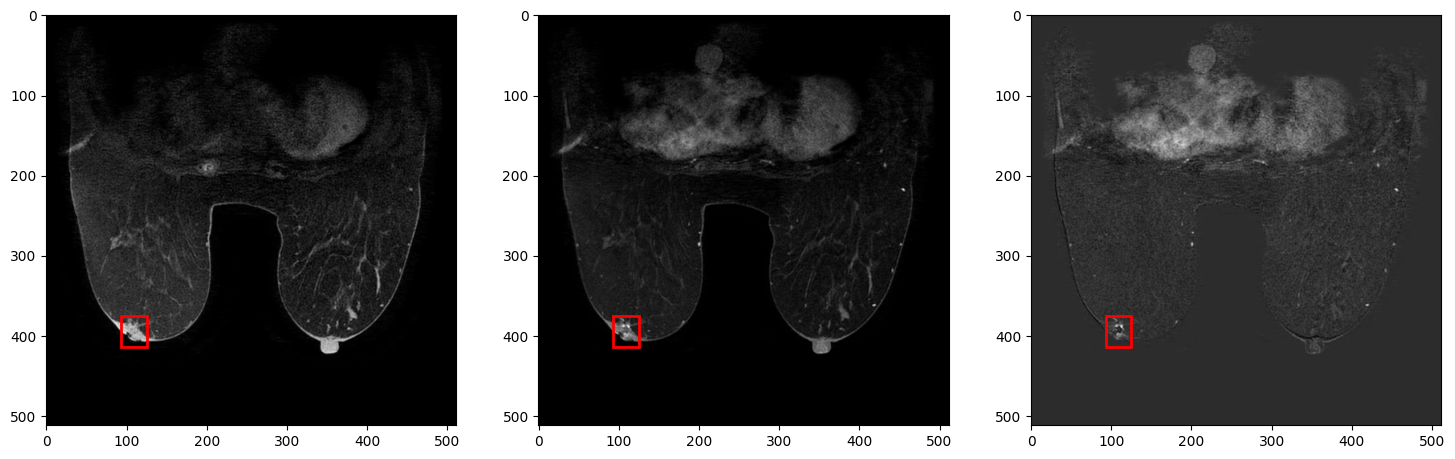

In [25]:
fig, ax = plt.subplots(1, 3, figsize = (18, 6))

# for patient_id in os.listdir(DATA_PATH):

patient_id = 'Breast_MRI_310'

patient_path = os.path.join(DATA_PATH, patient_id)

s_row, e_row, s_col, e_col, s_slice, e_slice = annotations.loc[patient_id].tolist()


pre_path = os.path.join(patient_path, 'pre.img.gz')
post_path = os.path.join(patient_path, 'post_1.img.gz')

pre_img = sitk.GetArrayFromImage(sitk.ReadImage(pre_path))
post_img = sitk.GetArrayFromImage(sitk.ReadImage(post_path))

mid_slice = int((s_slice + e_slice)/2)




ax[0].imshow(pre_img[mid_slice, :, :], cmap = 'gray')
ax[0].add_patch( patches.Rectangle((s_col, s_row), e_col - s_col, e_row - s_row, fill = False, edgecolor = 'red', lw = 2))
ax[1].imshow(post_img[mid_slice, :, :], cmap = 'gray')
ax[1].add_patch( patches.Rectangle((s_col, s_row), e_col - s_col, e_row - s_row, fill = False, edgecolor = 'red', lw = 2))
ax[2].imshow((post_img - pre_img)[mid_slice, :, :], cmap = 'gray')
ax[2].add_patch( patches.Rectangle((s_col, s_row), e_col - s_col, e_row - s_row, fill = False, edgecolor = 'red', lw = 2))


# fig.clear()

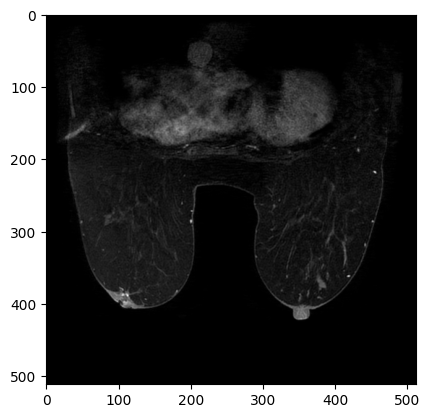

In [26]:
myslice = post_img[mid_slice, :, :]
plt.imshow(myslice, cmap = 'gray')

In [27]:
arr = sitk.GetArrayFromImage(sitk.ReadImage(post_path))
rescaled = ((arr - arr.min()) * 255. / (arr.max() - arr.min()))
# post_img_255 = sitk.Cast(sitk.RescaleIntensity(post_img), sitk.sitkUInt8)

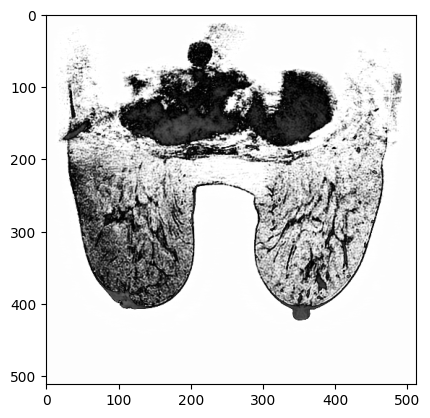

In [31]:
cntr, u, u0, d, jm, p, fpc = skfuzzy.cmeans(rescaled[mid_slice, :, :].flatten()[np.newaxis, :], 2, 2, 0.002, 1000)

myshape = rescaled.shape
u.shape

segmented_cmeans = u.T.reshape((myshape[1], myshape[2], 2))[:, :, 1]

plt.imshow(segmented_cmeans, cmap = 'gray')

In [17]:
mid_slice

37

In [18]:
annotations.loc[patient_id]

Start Row       375
End Row         414
Start Column     93
End Column      125
Start Slice      27
End Slice        47
Name: Breast_MRI_310, dtype: int64

In [41]:
thresh = (rescaled > 30).astype('int')


def plot(myslice):
    plt.imshow(thresh[myslice, :, :], cmap = 'gray')


interact(plot, myslice = ipywidgets.IntSlider(value=1, min=0, max=thresh.shape[0], step=1))

interactive(children=(IntSlider(value=1, description='myslice', max=170), Output()), _dom_classes=('widget-int…

<function __main__.plot(myslice)>

In [20]:
rescaled.shape

(512, 512, 170)

In [43]:
otsu_filter = sitk.OtsuThresholdImageFilter()
otsu_filter.SetInsideValue(0)
otsu_filter.SetOutsideValue(1)


image_sitk = sitk.GetImageFromArray(rescaled.transpose((1, 2, 0)))
seg = otsu_filter.Execute(image_sitk)
seg = sitk.GetArrayFromImage(seg)


def plot(myslice):
    plt.imshow(seg[myslice, :, :], cmap = 'gray')


interact(plot3, slice = ipywidgets.IntSlider(value=1, min=0, max=thresh.shape[0], step=1))

interactive(children=(IntSlider(value=1, description='slice', max=170), Output()), _dom_classes=('widget-inter…

<function __main__.plot3(slice)>

In [38]:
otsu_filter.GetThreshold()

15.938745498657227

In [44]:
thresholds = skimage.filters.threshold_multiotsu(rescaled.transpose((1, 2, 0)), classes = 2, nbins = 256)
regions = np.digitize(rescaled.transpose((1, 2, 0)), bins=thresholds)
def plot2(slice):
    plt.imshow(regions[:, :, slice], cmap = 'gray')


interact(plot2, slice = ipywidgets.IntSlider(value=1, min=0, max=thresh.shape[0], step=1))

interactive(children=(IntSlider(value=1, description='slice', max=170), Output()), _dom_classes=('widget-inter…

<function __main__.plot2(slice)>